<a href="https://colab.research.google.com/github/Yaakov-Sternberg/AAI-500-Stats-Project/blob/main/Histopathological_Images_Project%2C_Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To do:
* Check for data-leakage or any other reason the results seem to be be so high
* To consider adding:
 * **More Pre-trained Models** (ex. ResNet50, InceptionV3, EfficientNet)
 * **Optimize Hyperparameter Tuning** (learning rates, batch sizes, and optimizer settings)
 * **Data Augmentation** (more sophisticated augmentation techniques to improve generalization)
 * **K-fold Cross-Validation** (more robust validation, but resource heavy)
 * **Ensemble Methods** (combine models)
 * **Grad-CAM** (CNN analysis)

# Loading libraries & Data

In [1]:
# Standard libraries
import os
import random
import hashlib
import datetime
from pathlib import Path

# Data processing & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, UnidentifiedImageError

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Input
)

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    roc_auc_score,
    recall_score,
    roc_curve,
    f1_score,
    auc,
)

Downloading Dataset from Kaggle

In [2]:
# Install Kaggle API
!pip install kaggle

# Import libraries for file upload
from google.colab import files

# Upload kaggle.json file
files.upload()

# Create the Kaggle directory and copy the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

# Unzip dataset quietly (suppress output)
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:54<00:00, 40.9MB/s]
100% 1.76G/1.76G [00:54<00:00, 34.8MB/s]


# **EDA & Pre-Processing**

EDA

Classes: ['lung_scc', 'lung_aca', 'lung_n', 'colon_n', 'colon_aca']
Number of images per class: {'lung_scc': 5000, 'lung_aca': 5000, 'lung_n': 5000, 'colon_n': 5000, 'colon_aca': 5000}


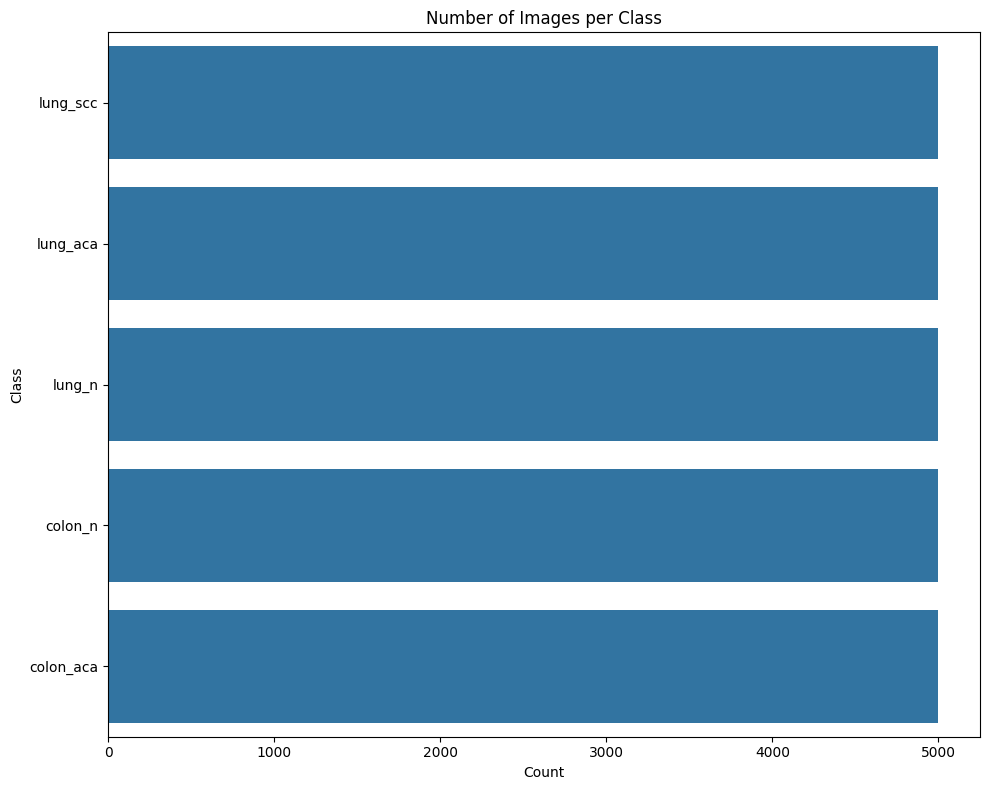

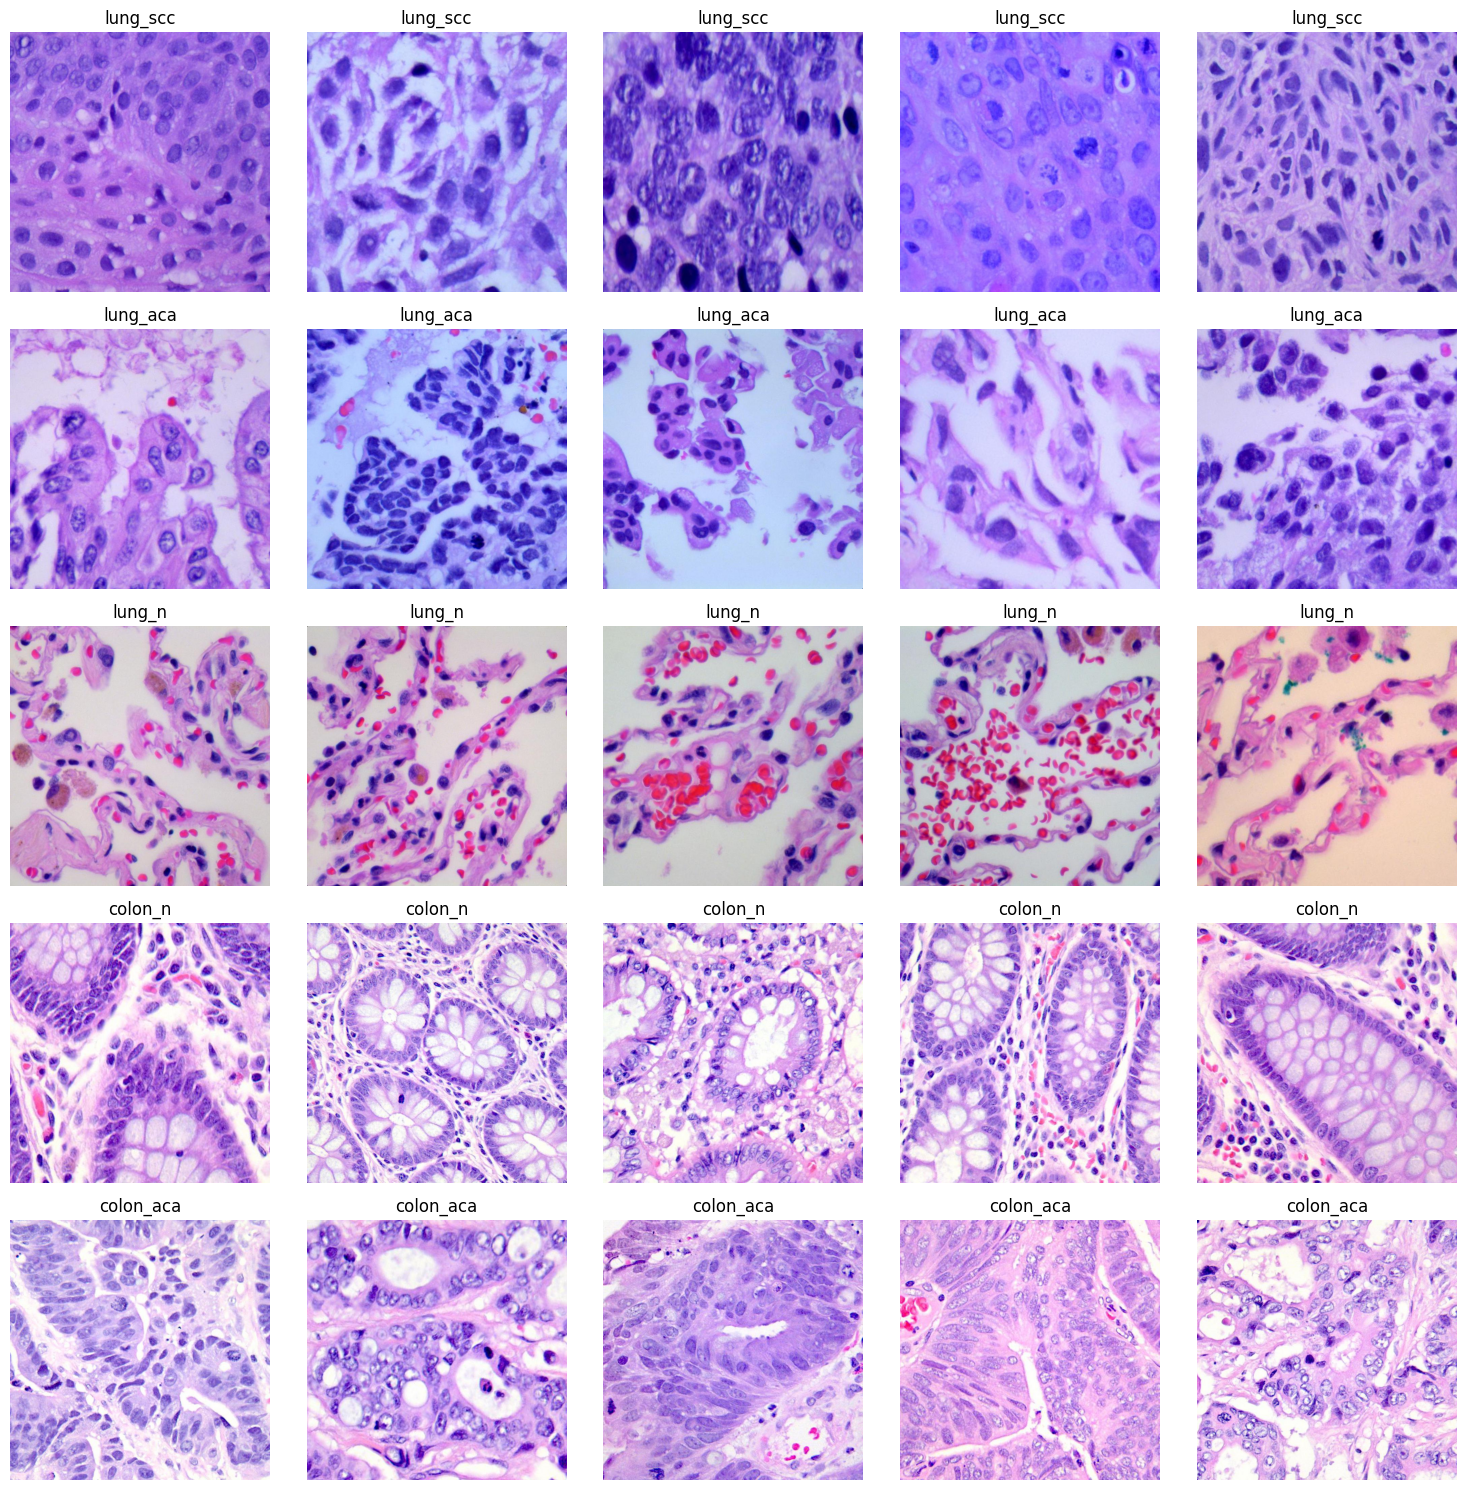

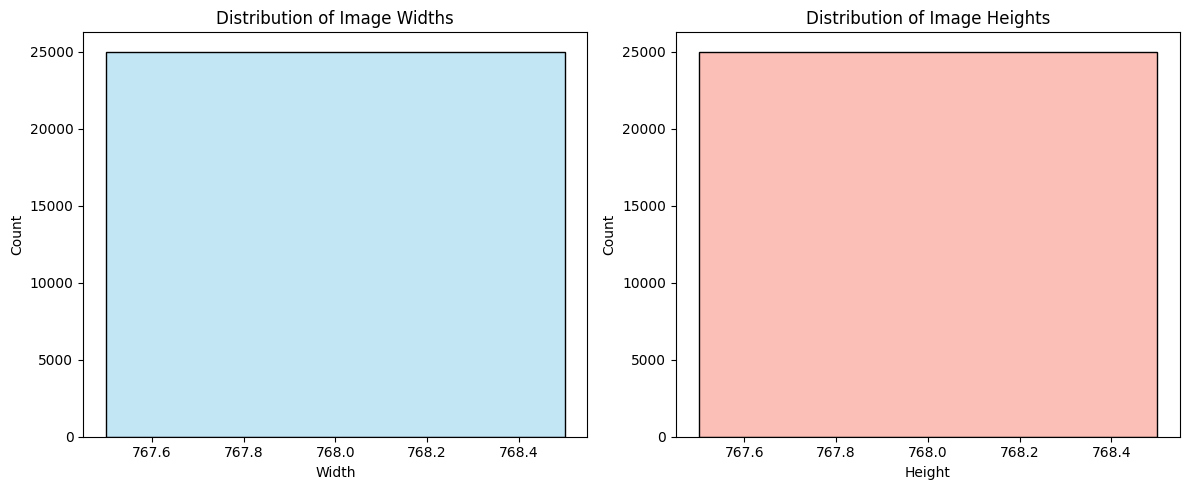


Image size summary statistics:
         Width   Height
count  25000.0  25000.0
mean     768.0    768.0
std        0.0      0.0
min      768.0    768.0
25%      768.0    768.0
50%      768.0    768.0
75%      768.0    768.0
max      768.0    768.0

Total duplicate images found: 1280
Removed 1280 duplicate image(s).

Updated number of images per class after removing duplicates: {'lung_scc': 4724, 'lung_aca': 4727, 'lung_n': 4744, 'colon_n': 4772, 'colon_aca': 4753}


In [3]:
data_dir = Path('data/lung_colon_image_set')
subdirs = ['lung_image_sets', 'colon_image_sets']

def get_classes(data_dir, subdirs):
    """Retrieve class paths from specified subdirectories."""
    class_paths = {}
    for subdir in subdirs:
        subdir_path = data_dir / subdir
        for cls in subdir_path.iterdir():
            if cls.is_dir():
                class_paths.setdefault(cls.name, []).append(cls)
    return class_paths

def plot_class_distribution(class_counts):
    """Plot the number of images per class."""
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_classes)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=counts, y=classes)
    plt.title('Number of Images per Class')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.legend([], [], frameon=False)  # Remove legend to suppress FutureWarning
    plt.tight_layout()
    plt.show()

def display_sample_images(class_paths, images_per_class=5):
    """Display a sample of images from each class."""
    num_classes = len(class_paths)

    # Adjust figure size based on number of classes
    fig_height = num_classes * 3 if num_classes > 0 else 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, fig_height))

    # Ensure axes is a 2D array
    if num_classes == 1:
        axes = [axes]

    for idx, (cls, paths) in enumerate(class_paths.items()):
        images = []
        for path in paths:
            images.extend(list(path.iterdir()))
        selected_images = random.sample(images, images_per_class)
        for i, img_path in enumerate(selected_images):
            with Image.open(img_path) as img:
                axes[idx, i].imshow(img)
            axes[idx, i].set_title(cls)
            axes[idx, i].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_image_sizes(class_paths):
    """Analyze and plot image size distributions."""
    image_sizes = []

    for cls, paths in class_paths.items():
        for path in paths:
            for img_path in path.iterdir():
                if img_path.is_file():
                    with Image.open(img_path) as img:
                        image_sizes.append(img.size)

    sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.histplot(sizes_df['Width'], kde=True, color='skyblue')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')

    plt.subplot(1,2,2)
    sns.histplot(sizes_df['Height'], kde=True, color='salmon')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')

    plt.tight_layout()
    plt.show()

    print("\nImage size summary statistics:")
    print(sizes_df.describe())

def find_and_remove_duplicates(class_paths):
    """Find and remove duplicate images based on MD5 hash."""
    hash_dict = {}
    duplicates = []

    for cls, paths in class_paths.items():
        for path in paths:
            for img_path in path.iterdir():
                if img_path.is_file():
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hash_dict:
                        duplicates.append(img_path)
                    else:
                        hash_dict[file_hash] = img_path

    total_duplicates = len(duplicates)
    print(f"\nTotal duplicate images found: {total_duplicates}")

    # Remove duplicates (without printing each removal)
    if total_duplicates > 0:
        for dup in duplicates:
            dup.unlink()
        print(f"Removed {total_duplicates} duplicate image(s).")
    else:
        print("No duplicate images found.")

def main():
    # Retrieve class paths
    class_paths = get_classes(data_dir, subdirs)

    # Calculate class counts
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}

    print("Classes:", list(class_counts.keys()))
    print("Number of images per class:", class_counts)

    # Plot class distribution
    plot_class_distribution(class_counts)

    # Display sample images
    display_sample_images(class_paths, images_per_class=5)

    # Analyze image sizes
    analyze_image_sizes(class_paths)

    # Find and remove duplicate images
    find_and_remove_duplicates(class_paths)

    # Recalculate class counts after removing duplicates
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}
    print("\nUpdated number of images per class after removing duplicates:", class_counts)

if __name__ == "__main__":
    main()


Data Preparation

In [4]:
# Creating a DataFrame of Image Paths and Labels
image_paths = []
labels = []

for subdir in ['lung_image_sets', 'colon_image_sets']:
    subdir_path = os.path.join(data_dir, subdir)
    for cls in os.listdir(subdir_path):
        cls_dir = os.path.join(subdir_path, cls)
        if not os.path.isdir(cls_dir):
            continue  # Skip if not a directory
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(cls)
            else:
                print(f"Missing or invalid file skipped: {img_path}")

# Create DataFrame
df = pd.DataFrame({'filename': image_paths, 'label': labels})
df.head()

print("Total samples:", len(df))
print("Missing filenames:", df['filename'].isnull().sum())
print("Missing labels:", df['label'].isnull().sum())

Total samples: 23720
Missing filenames: 0
Missing labels: 0


In [5]:
# Encoding Labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print("Encoded labels:", list(label_encoder.classes_))


Encoded labels: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Data Splitting

In [6]:
# Split the dataset into training (60%), validation (20%), and test (20%) sets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_val_idx, test_idx in split.split(df, df['label_encoded']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1234)
for train_idx, val_idx in split_val.split(train_val_df, train_val_df['label_encoded']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]


print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

print("Training set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("Validation set class distribution:")
print(val_df['label'].value_counts(normalize=True))
print("Test set class distribution:")
print(test_df['label'].value_counts(normalize=True))

# Check if all image files exist
# (to troubleshoot "UserWarning: Your input ran out of data")
for df in [train_df, val_df, test_df]:
    missing_files = df[~df['filename'].apply(os.path.exists)]
    if not missing_files.empty:
        print("Missing files detected:")
        print(missing_files)

Training set size: 14232
Validation set size: 4744
Test set size: 4744
Training set class distribution:
label
colon_n      0.201237
colon_aca    0.200393
lung_n       0.199972
lung_aca     0.199269
lung_scc     0.199129
Name: proportion, dtype: float64
Validation set class distribution:
label
colon_n      0.201096
colon_aca    0.200253
lung_n       0.200042
lung_aca     0.199410
lung_scc     0.199199
Name: proportion, dtype: float64
Test set class distribution:
label
colon_n      0.201096
colon_aca    0.200464
lung_n       0.200042
lung_aca     0.199199
lung_scc     0.199199
Name: proportion, dtype: float64


# Modeling Methods

In [7]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '1234'
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

# Define image sizes and batch size
IMG_SIZES = {
    'cnn': (224, 224),        # For the CNN model (I'd like to see if increases improves training)
    'vgg16': (224, 224)       # For the VGG16 model
}
BATCH_SIZE = 32
NUM_CLASSES = 5


all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
CLASSES = list(label_encoder.classes_)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_dict = dict(enumerate(class_weights))

# Function to create data generators
def create_generators(train_df, val_df, test_df, img_size, batch_size, model_type='cnn', seed=1234):
    if model_type == 'vgg16':
        preprocessing_function = preprocess_input
    else:
        preprocessing_function = None

    train_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=5
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function
    )

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    val_gen = test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    test_gen = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    return train_gen, val_gen, test_gen

# Create generators for CNN
train_gen_cnn, val_gen_cnn, test_gen_cnn = create_generators(
    train_df, val_df, test_df, IMG_SIZES['cnn'], BATCH_SIZE, model_type='cnn'
)

# Create generators for VGG16
train_gen_vgg16, val_gen_vgg16, test_gen_vgg16 = create_generators(
    train_df, val_df, test_df, IMG_SIZES['vgg16'], BATCH_SIZE, model_type='vgg16'
)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Model-specific checkpoint filepaths
checkpoint_filepath_cnn = f'cnn_model_{timestamp}.keras'
checkpoint_filepath_vgg16 = f'vgg16_model_{timestamp}.keras'

model_checkpoint_cnn = ModelCheckpoint(
    filepath=checkpoint_filepath_cnn,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

model_checkpoint_vgg16 = ModelCheckpoint(
    filepath=checkpoint_filepath_vgg16,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# TensorBoard callback for logging
tensorboard_callback = TensorBoard(log_dir='./logs')

# Variables
epochs = 10  # Adjust based on resource availability

# Build CNN Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile CNN model
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)


# Build VGG16 Transfer Learning Model
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build & compile VGG16 model
model_vgg16 = build_vgg16_model(IMG_SIZES['vgg16'] + (3,), NUM_CLASSES)
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

model_cnn.summary()
model_vgg16.summary()

Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,014,245 (99.24 MB)

 Trainable params: 26,012,581 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,325 (56.64 MB)

 Trainable params: 133,125 (520.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

CNN Attempt 6

In [ ]:
# Build and compile CNN model
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Train CNN model
history_cnn = model_cnn.fit(
    train_gen_cnn,
    epochs=epochs,
    validation_data=val_gen_cnn,
    callbacks=[early_stopping, model_checkpoint_cnn, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best CNN model
best_model_cnn = load_model(checkpoint_filepath_cnn)

# Evaluate CNN model on test data
test_metrics_cnn = best_model_cnn.evaluate(test_gen_cnn, verbose=1)
metric_names = best_model_cnn.metrics_names
for name, value in zip(metric_names, test_metrics_cnn):
    print(f"{name}: {value}")

# Save final model
best_model_cnn.save(f'final_cnn_model_{timestamp}.keras')


Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
train_gen_cnn.class_indices: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6369 - auc: 0.8820 - loss: 1.0417 - precision: 0.6657 - recall: 0.5960
Epoch 1: val_loss improved from inf to 1.79022, saving model to cnn_model_20241209-031944.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 333s 671ms/step - accuracy: 0.6370 - auc: 0.8821 - loss: 1.0411 - precision: 0.6659 - recall: 0.5962 - val_accuracy: 0.4884 - val_auc: 0.7766 - val_loss: 1.7902 - val_precision: 0.4904 - val_recall: 0.4616 - learning_rate: 1.0000e-04
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8066 - auc: 0.9645 - loss: 0.5189 - precision: 0.8183 - recall: 0.7921
Epoch 2: val_loss did not improve from 1.79022
445/445 ━━━━━━━━━━━━━━━━━━━━ 331s 607ms/step - accuracy: 0.8066 - auc: 0.9645 - loss: 0.5188 - precision: 0.8183 - recall: 0.7921 - val_accuracy: 0.6199 - val_auc: 0.8465 - val_loss: 2.0190 - val_precision: 0.6217 - val_recall: 0.6170 - learning_rate: 1.0000e-04
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy

CNN Atempt 7

In [ ]:
# Build and compile CNN model
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Train CNN model
history_cnn = model_cnn.fit(
    train_gen_cnn,
    epochs=epochs,
    validation_data=val_gen_cnn,
    callbacks=[early_stopping, model_checkpoint_cnn, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best CNN model
best_model_cnn = load_model(checkpoint_filepath_cnn)

# Evaluate CNN model on test data
test_metrics_cnn = best_model_cnn.evaluate(test_gen_cnn, verbose=1)
metric_names = best_model_cnn.metrics_names
for name, value in zip(metric_names, test_metrics_cnn):
    print(f"{name}: {value}")

# Save final model
best_model_cnn.save(f'final_cnn_model_{timestamp}.keras')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.6267 - auc: 0.8862 - loss: 1.0298 - precision: 0.6488 - recall: 0.5872
Epoch 1: val_loss improved from inf to 4.63335, saving model to cnn_model_20241209-072952.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 406s 866ms/step - accuracy: 0.6269 - auc: 0.8863 - loss: 1.0292 - precision: 0.6490 - recall: 0.5874 - val_accuracy: 0.2578 - val_auc: 0.6047 - val_loss: 4.6334 - val_precision: 0.2617 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8092 - auc: 0.9643 - loss: 0.5238 - precision: 0.8212 - recall: 0.7938
Epoch 2: val_loss improved from 4.63335 to 1.42502, saving model to cnn_model_20241209-072952.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 377s 742ms/step - accuracy: 0.8092 - auc: 0.9643 - loss: 0.5237 - precision: 0.8212 - recall: 0.7939 - val_accuracy: 0.6773 - val_auc: 0.8953 - val_loss: 1.4250 - val_precision: 0.6793 - val_recall: 0.6716 - learning_rate: 1.0000e-04
Epoch 3/10


In [ ]:
# Save to drive:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory if it doesn't exist
import os
save_path = '/content/drive/MyDrive/ml_models7' # Change load model accordingly
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save CNN model & history
model_cnn.save(f'{save_path}/cnn_model.keras')
import json
with open(f'{save_path}/cnn_history.json', 'w') as f:
    json.dump(history_cnn.history, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


VGG16 Atempt 7 (deleted 6 accidentally, might retrieve it later)

In [ ]:
# Train VGG16 model
history_vgg16 = model_vgg16.fit(
    train_gen_vgg16,
    epochs=epochs,
    validation_data=val_gen_vgg16,
    callbacks=[early_stopping, model_checkpoint_vgg16, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load best VGG16 model
best_model_vgg16 = load_model(checkpoint_filepath_vgg16)

# Evaluate VGG16 model on test data
test_metrics_vgg16 = best_model_vgg16.evaluate(test_gen_vgg16)
print(f"VGG16 Test Metrics: {test_metrics_vgg16}")

# Fine-tune VGG16 model
# Unfreeze top layers of base model
base_model_vgg16 = best_model_vgg16.layers[0]  # Get base model
base_model_vgg16.trainable = True

# Freeze layers except last convolutional block
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False

# Recompile model with a lower learning rate
best_model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Continue training (fine-tuning)
history_vgg16_ft = best_model_vgg16.fit(
    train_gen_vgg16,
    epochs=epochs,
    validation_data=val_gen_vgg16,
    callbacks=[early_stopping, model_checkpoint_vgg16, reduce_lr, tensorboard_callback],
    class_weight=class_weights_dict,
    verbose=1
)

# Load fine-tuned VGG16 model
fine_tuned_model_vgg16 = load_model(checkpoint_filepath_vgg16)

# Evaluate fine-tuned model on test data
fine_tuned_test_metrics_vgg16 = fine_tuned_model_vgg16.evaluate(test_gen_vgg16)
print(f"Fine-tuned VGG16 Test Metrics: {fine_tuned_test_metrics_vgg16}")

# Save final models
fine_tuned_model_vgg16.save(f'fine_tuned_vgg16_model_{timestamp}.keras')

# Save VGG16 model & histories
model_vgg16.save(f'{save_path}/vgg16_model.keras')
with open(f'{save_path}/vgg16_history.json', 'w') as f:
    json.dump(history_vgg16.history, f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'w') as f:
    json.dump(history_vgg16_ft.history, f)

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6002 - auc: 0.8457 - loss: 1.1754 - precision: 0.6458 - recall: 0.5369
Epoch 1: val_loss improved from inf to 0.22031, saving model to vgg16_model_20241209-072952.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 330s 718ms/step - accuracy: 0.6005 - auc: 0.8460 - loss: 1.1743 - precision: 0.6461 - recall: 0.5373 - val_accuracy: 0.9180 - val_auc: 0.9926 - val_loss: 0.2203 - val_precision: 0.9249 - val_recall: 0.9110 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8834 - auc: 0.9851 - loss: 0.3256 - precision: 0.8947 - recall: 0.8660
Epoch 2: val_loss improved from 0.22031 to 0.17766, saving model to vgg16_model_20241209-072952.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 347s 648ms/step - accuracy: 0.8834 - auc: 0.9851 - loss: 0.3256 - precision: 0.8947 - recall: 0.8661 - val_accuracy: 0.9340 - val_auc: 0.9947 - val_loss: 0.1777 - val_precision: 0.9389 - val_recall: 0.9290 - learning_rate: 1.0000e

In [ ]:
# Save final models
fine_tuned_model_vgg16.save(f'fine_tuned_vgg16_model_{timestamp}.keras')

# Save VGG16 model & histories
model_vgg16.save(f'{save_path}/vgg16_model.keras')
with open(f'{save_path}/vgg16_history.json', 'w') as f:
    json.dump(history_vgg16.history, f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'w') as f:
    json.dump(history_vgg16_ft.history, f)

# Load Model

In [ ]:
# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
import json

save_path = '/content/drive/MyDrive/ml_models7'# Keep in sync with load model

# Load models
loaded_cnn = load_model(f'{save_path}/cnn_model.keras')
loaded_vgg16 = load_model(f'{save_path}/vgg16_model.keras')

# Load training histories
with open(f'{save_path}/cnn_history.json', 'r') as f:
    loaded_cnn_history = json.load(f)
with open(f'{save_path}/vgg16_history.json', 'r') as f:
    loaded_vgg16_history = json.load(f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'r') as f:
    loaded_vgg16_ft_history = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Validation & Performance Metrics

In [ ]:
# Evaluate CNN on Test Set
print("\n CNN Test Results:")
loss_cnn_test, accuracy_cnn_test, auc_cnn_test, precision_cnn_test, recall_cnn_test = loaded_cnn.evaluate(test_gen_cnn)
print(f"Test Accuracy: {accuracy_cnn_test*100:.2f}%")
print(f"Test AUC: {auc_cnn_test:.4f}")
print(f"Test Precision: {precision_cnn_test:.4f}")
print(f"Test Recall: {recall_cnn_test:.4f}")


# Evaluate VGG16 Fine-Tuned Model on Test Set
print("\nVGG16 Fine-Tuned Test Results:")
loss_vgg16_test, accuracy_vgg16_test, auc_vgg16_test, precision_vgg16_test, recall_vgg16_test = loaded_vgg16.evaluate(test_gen_vgg16)
print(f"Test Accuracy: {accuracy_vgg16_test*100:.2f}%")
print(f"Test AUC: {auc_vgg16_test:.4f}")
print(f"Test Precision: {precision_vgg16_test:.4f}")
print(f"Test Recall: {recall_vgg16_test:.4f}")


 CNN Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9440 - auc: 0.9971 - loss: 0.1369 - precision: 0.9457 - recall: 0.9440
Test Accuracy: 94.14%
Test AUC: 0.9969
Test Precision: 0.9428
Test Recall: 0.9414

VGG16 Fine-Tuned Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - accuracy: 0.9166 - auc: 0.9916 - loss: 0.2350 - precision: 0.9224 - recall: 0.9066
Test Accuracy: 91.80%
Test AUC: 0.9920
Test Precision: 0.9245
Test Recall: 0.9091


# Modeling Results & Findings:

* confusion matrices
* training history
* ROC curves

In [ ]:
# Helper function for confusion matrix plotting
def plot_confusion_matrix(model, generator, title):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES,
                yticklabels=CLASSES)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# Plot confusion matrices
plot_confusion_matrix(loaded_cnn, test_gen_cnn, 'Enhanced CNN Confusion Matrix')
plot_confusion_matrix(loaded_vgg16, test_gen_vgg16, 'VGG16 Fine-Tuned Confusion Matrix')

# Helper function for plotting training history
def plot_training_history(histories, titles):
    plt.figure(figsize=(15,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    for history, title in zip(histories, titles):
        plt.plot(history.history['accuracy'], label=f'{title} Train')
        plt.plot(history.history['val_accuracy'], label=f'{title} Val')
    plt.title('Model Accuracy Comparison', pad=20)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    for history, title in zip(histories, titles):
        plt.plot(history.history['loss'], label=f'{title} Train')
        plt.plot(history.history['val_loss'], label=f'{title} Val')
    plt.title('Model Loss Comparison', pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training histories
histories = [history_cnn, history_vgg16, history_vgg16_ft]
titles = ['Enhanced CNN', 'VGG16', 'VGG16 Fine-Tuned']

plot_training_history(histories, titles)



# Summarize & Compare Model Performance

# Prepare a DataFrame with results
results = pd.DataFrame({
    'Model': ['Enhanced CNN', 'VGG16 Fine-Tuned'],
    'Test Accuracy (%)': [
        accuracy_cnn_test * 100,
        accuracy_vgg16_test * 100
    ],
    'Test AUC': [auc_cnn_test, auc_vgg16_test],
    'Test Precision': [precision_cnn_test, precision_vgg16_test],
    'Test Recall': [recall_cnn_test, recall_vgg16_test]
})

print(results)

# Plot test accuracies
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Test Accuracy (%)', data=results)
plt.title('Model Test Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.ylim(0, 100)
plt.show()


NameError: name 'loaded_cnn' is not defined

ROC Curves

149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step


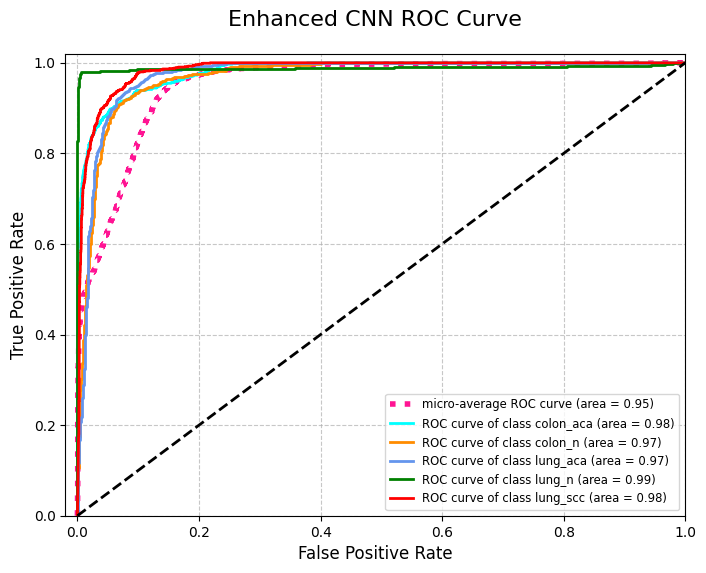

149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step


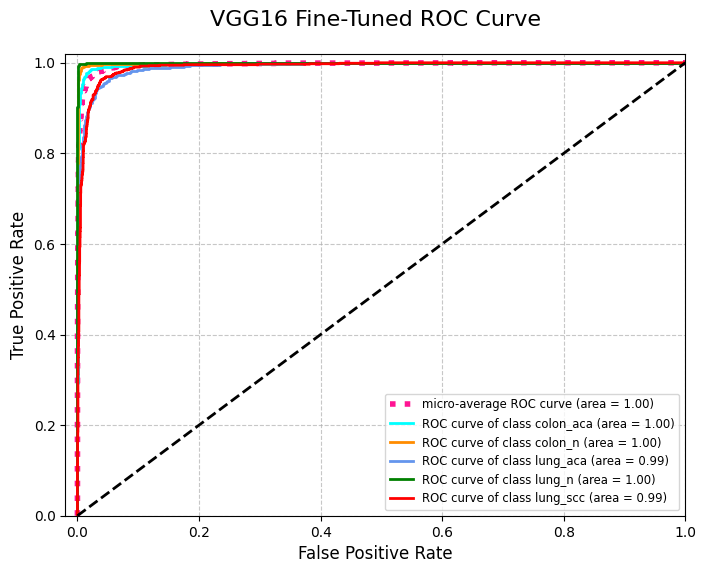

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interpolate
from itertools import cycle

def plot_multiclass_roc(model, generator, n_classes, title):
    y_score = model.predict(generator)
    y_true = generator.classes
    y_true = label_binarize(y_true, classes=range(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'gray', 'olive', 'cyan'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASSES[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run:
n_classes = len(CLASSES)
plot_multiclass_roc(loaded_cnn, test_gen_cnn, n_classes, 'Enhanced CNN ROC Curve')
plot_multiclass_roc(loaded_vgg16, test_gen_vgg16, n_classes, 'VGG16 Fine-Tuned ROC Curve')

Precision-Recall Curves

149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step


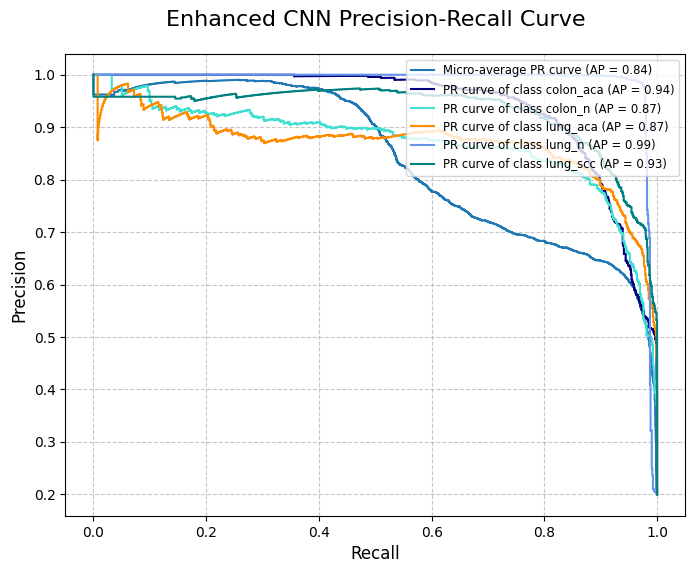

149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step


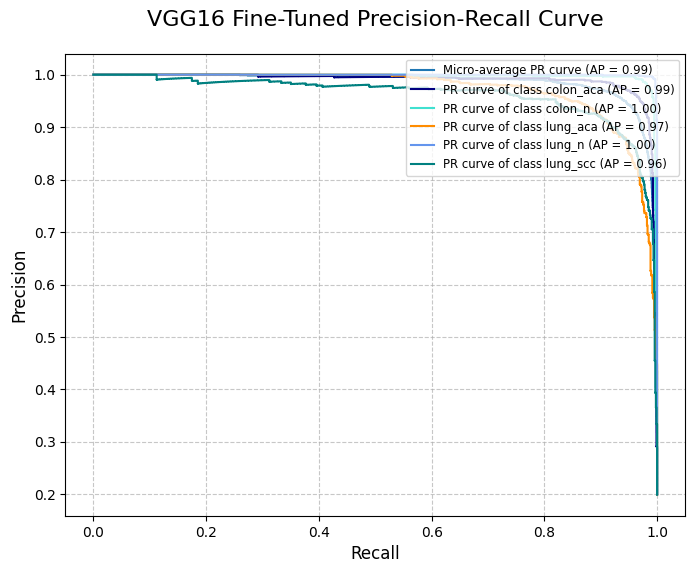

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, generator, title):
    y_score = model.predict(generator)
    y_true = generator.classes
    y_true = label_binarize(y_true, classes=range(n_classes))

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], y_score[:, i])

    # Plot the micro-average Precision-Recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_score, average="micro")

    plt.figure(figsize=(8,6))
    plt.step(recall['micro'], precision['micro'], where='post', label=f'Micro-average PR curve (AP = {average_precision["micro"]:.2f})')

    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    for i, color in zip(range(n_classes), colors):
        plt.step(recall[i], precision[i], where='post', color=color,
                 label=f'PR curve of class {CLASSES[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Run:
plot_precision_recall_curve(loaded_cnn, test_gen_cnn, 'Enhanced CNN Precision-Recall Curve')
plot_precision_recall_curve(loaded_vgg16, test_gen_vgg16, 'VGG16 Fine-Tuned Precision-Recall Curve')


Confusion Matrix Normalization:

149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step


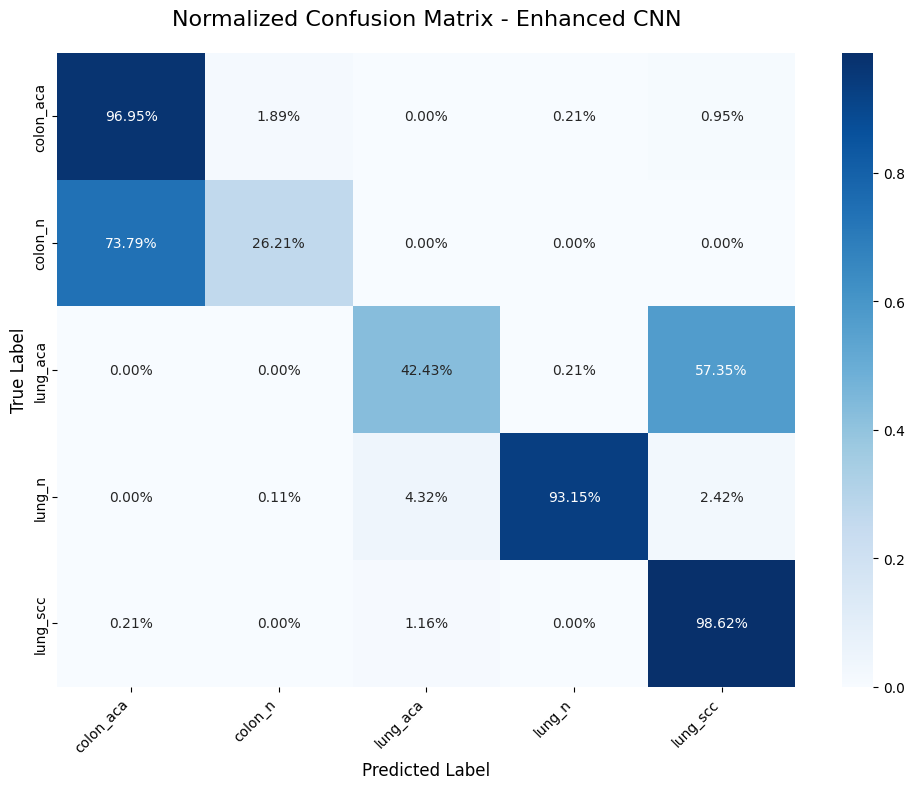

149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step


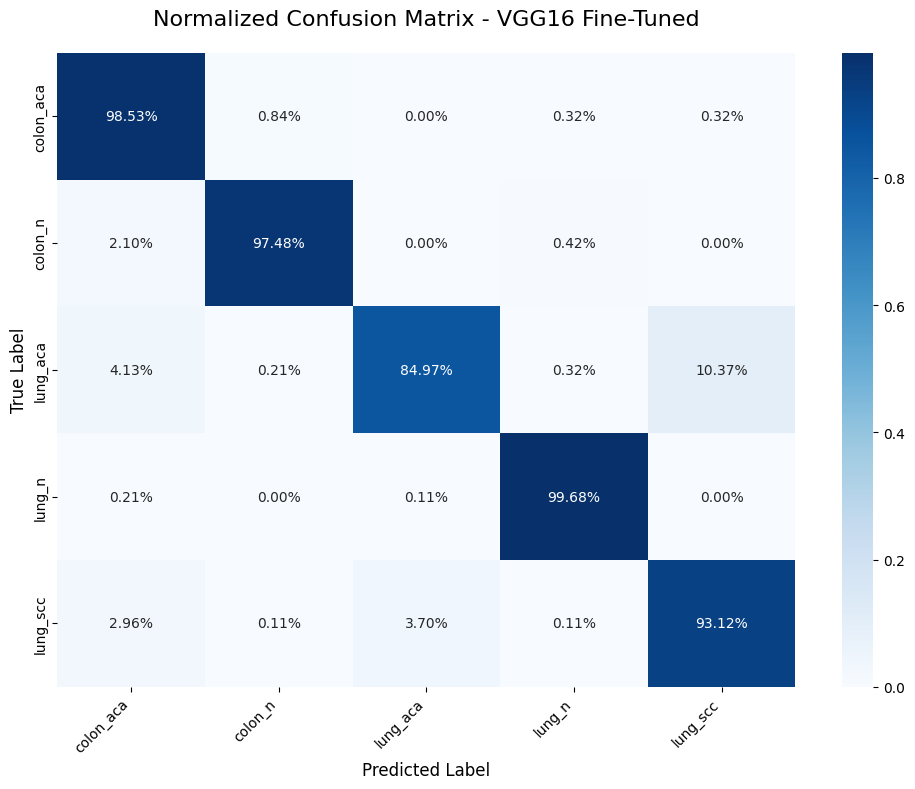

In [ ]:
def plot_normalized_confusion_matrix(model, generator, title):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred_classes, normalize='true')  # Normalized confusion matrix

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(title, fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Run:
plot_normalized_confusion_matrix(loaded_cnn, test_gen_cnn, 'Normalized Confusion Matrix - Enhanced CNN')
plot_normalized_confusion_matrix(loaded_vgg16, test_gen_vgg16, 'Normalized Confusion Matrix - VGG16 Fine-Tuned')


149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.8708 - auc: 0.9739 - loss: 0.4758 - precision: 0.8720 - recall: 0.8688
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.9411 - auc: 0.9956 - loss: 0.1575 - precision: 0.9427 - recall: 0.9405


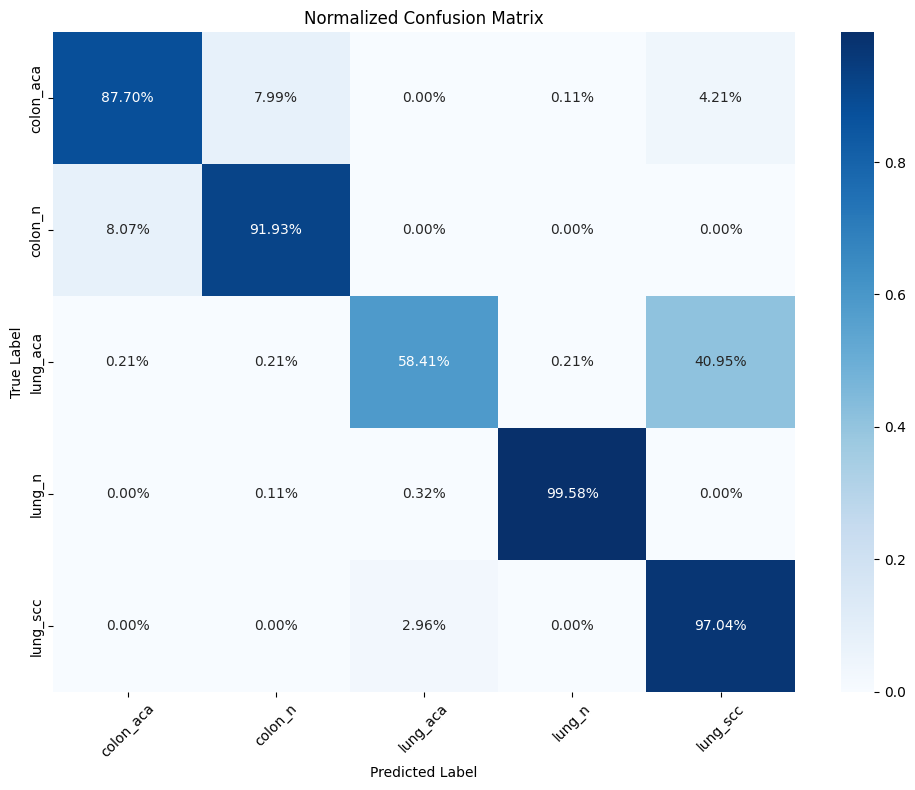


Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.91      0.88      0.89       951
     colon_n       0.92      0.92      0.92       954
    lung_aca       0.95      0.58      0.72       945
      lung_n       1.00      1.00      1.00       949
    lung_scc       0.68      0.97      0.80       945

    accuracy                           0.87      4744
   macro avg       0.89      0.87      0.87      4744
weighted avg       0.89      0.87      0.87      4744



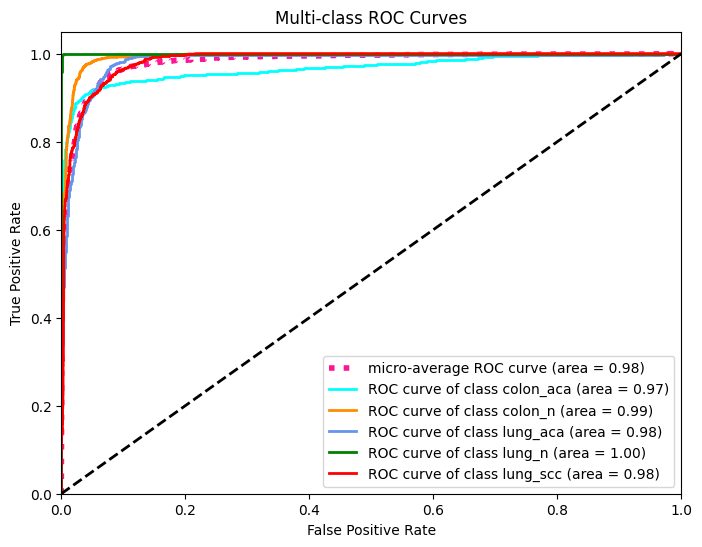

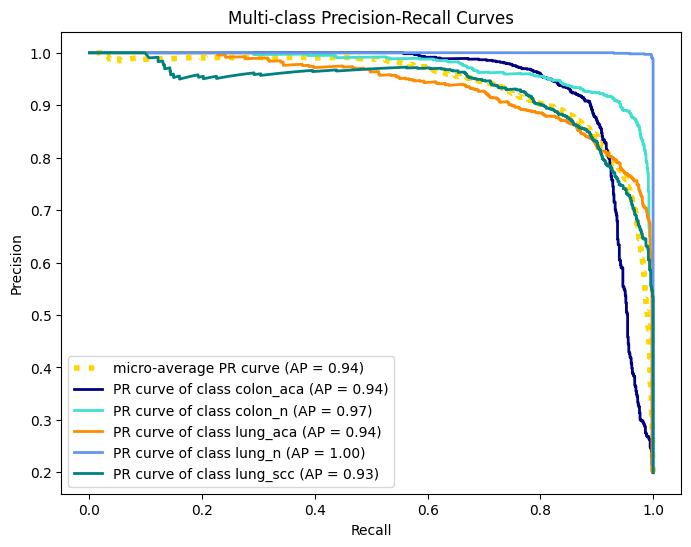

149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.8708 - auc: 0.9739 - loss: 0.4758 - precision: 0.8720 - recall: 0.8688
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9411 - auc: 0.9956 - loss: 0.1575 - precision: 0.9427 - recall: 0.9405

Model Comparison Summary:
    Accuracy       AUC  Precision    Recall      Loss         Model
0  86.951941  0.972730   0.870429  0.868044  0.493333    sequential
1  94.287521  0.995677   0.945397  0.941610  0.157908  sequential_1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from scipy import interpolate
from itertools import cycle

class ModelEvaluator:
    def __init__(self, model, generator, class_names):
        """
        Initialize ModelEvaluator with a model and its test data generator.

        Args:
            model: Trained model instance
            generator: Data generator for evaluation
            class_names: List of class names
        """
        self.model = model
        self.generator = generator
        self.class_names = class_names
        self._cache = {}

    def _get_predictions(self):
        """Get or compute model predictions using caching."""
        if 'predictions' not in self._cache:
            self._cache['predictions'] = self.model.predict(self.generator)
        return self._cache['predictions']

    def _get_true_labels(self):
        """Get true labels from generator."""
        if 'true_labels' not in self._cache:
            self._cache['true_labels'] = self.generator.classes
        return self._cache['true_labels']

    def _get_predicted_classes(self):
        """Get predicted class indices."""
        if 'predicted_classes' not in self._cache:
            predictions = self._get_predictions()
            self._cache['predicted_classes'] = np.argmax(predictions, axis=1)
        return self._cache['predicted_classes']

    def plot_confusion_matrix(self, normalized=False, figsize=(10, 8)):
        """Plot confusion matrix."""
        y_pred_classes = self._get_predicted_classes()
        y_true = self._get_true_labels()

        if normalized:
            cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
            fmt = '.2%'
        else:
            cm = confusion_matrix(y_true, y_pred_classes)
            fmt = 'd'

        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title('Normalized Confusion Matrix' if normalized else 'Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=self.class_names))

    def plot_multiclass_roc(self, figsize=(8, 6)):
        """Plot ROC curves for all classes."""
        y_score = self._get_predictions()
        y_true = self._get_true_labels()
        n_classes = len(self.class_names)

        # Binarize the labels for ROC curve calculation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(figsize=figsize)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {self.class_names[i]} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self, figsize=(8, 6)):
        """Plot precision-recall curves for all classes."""
        y_score = self._get_predictions()
        y_true = self._get_true_labels()
        n_classes = len(self.class_names)

        # Binarize the labels
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

        # Compute micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_true_bin.ravel(), y_score.ravel())
        average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

        plt.figure(figsize=figsize)
        plt.plot(recall["micro"], precision["micro"],
                 label=f'micro-average PR curve (AP = {average_precision["micro"]:.2f})',
                 color='gold', linestyle=':', linewidth=4)

        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2,
                     label=f'PR curve of class {self.class_names[i]} (AP = {average_precision[i]:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Multi-class Precision-Recall Curves')
        plt.legend(loc='lower left')
        plt.show()

    def get_metrics(self):
        """Calculate and return all evaluation metrics."""
        y_pred = self._get_predictions()
        y_true = self._get_true_labels()
        y_pred_classes = self._get_predicted_classes()

        # Calculate metrics using model.evaluate()
        loss, accuracy, auc_score, precision, recall = self.model.evaluate(self.generator)

        metrics = {
            'Accuracy': accuracy * 100,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'Loss': loss
        }

        return pd.DataFrame([metrics])

# Example usage:
def compare_models(models, generators, class_names):
    """Compare multiple models using the ModelEvaluator."""
    results = []
    evaluators = []

    for model, generator in zip(models, generators):
        evaluator = ModelEvaluator(model, generator, class_names)
        metrics = evaluator.get_metrics()
        metrics['Model'] = model.name
        results.append(metrics)
        evaluators.append(evaluator)

    # Combine all results
    comparison_df = pd.concat(results, ignore_index=True)
    return comparison_df, evaluators

# Run:
# Initialize evaluators for both models
cnn_evaluator = ModelEvaluator(loaded_cnn, test_gen_cnn, CLASSES)
vgg16_evaluator = ModelEvaluator(loaded_vgg16, test_gen_vgg16, CLASSES)

# Get and display metrics
cnn_metrics = cnn_evaluator.get_metrics()
vgg16_metrics = vgg16_evaluator.get_metrics()

# Plot visualizations
cnn_evaluator.plot_confusion_matrix(normalized=True)
cnn_evaluator.plot_multiclass_roc()
cnn_evaluator.plot_precision_recall_curve()

# Compare models
models = [loaded_cnn, loaded_vgg16]
generators = [test_gen_cnn, test_gen_vgg16]
comparison_results, evaluators = compare_models(models, generators, CLASSES)
print("\nModel Comparison Summary:")
print(comparison_results)

149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9440 - auc: 0.9971 - loss: 0.1369 - precision: 0.9457 - recall: 0.9440
CNN Metrics:
    Accuracy       AUC  Precision  Recall  F1-score  \
0  94.139963  0.996889   0.942791  0.9414  0.941503   

   Matthews Correlation Coefficient      Loss  
0                          0.927081  0.142239  
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.9166 - auc: 0.9916 - loss: 0.2350 - precision: 0.9224 - recall: 0.9066
VGG16 Metrics:
    Accuracy       AUC  Precision    Recall  F1-score  \
0  91.800171  0.991972   0.924544  0.909148  0.917964   

   Matthews Correlation Coefficient      Loss  
0                          0.897848  0.228698  


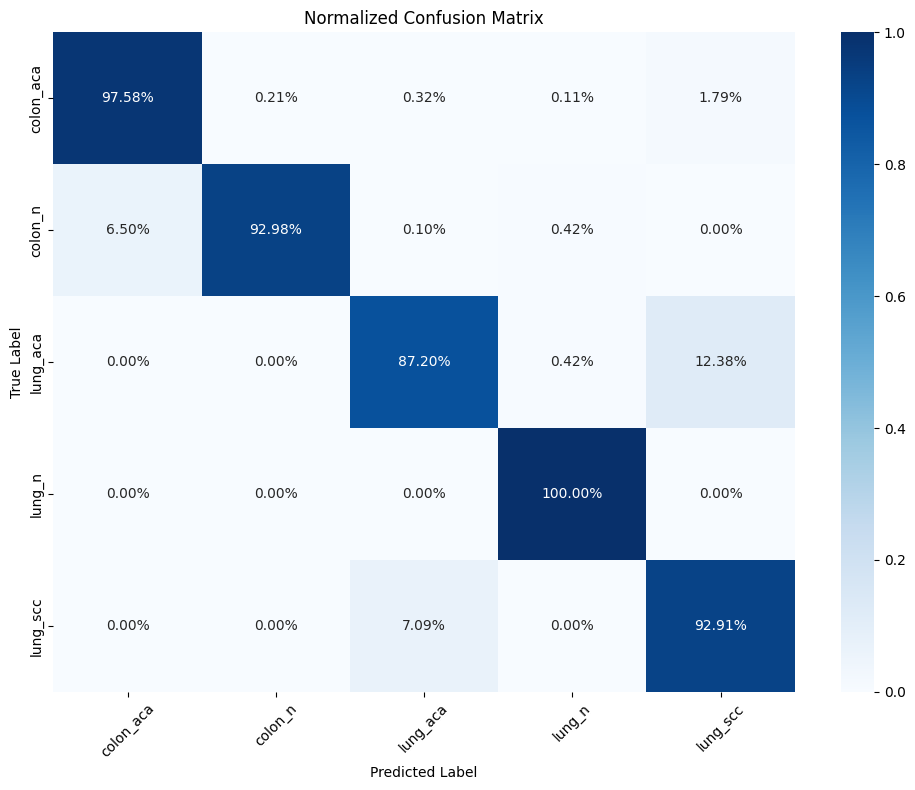


Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.94      0.98      0.96       951
     colon_n       1.00      0.93      0.96       954
    lung_aca       0.92      0.87      0.90       945
      lung_n       0.99      1.00      1.00       949
    lung_scc       0.87      0.93      0.90       945

    accuracy                           0.94      4744
   macro avg       0.94      0.94      0.94      4744
weighted avg       0.94      0.94      0.94      4744



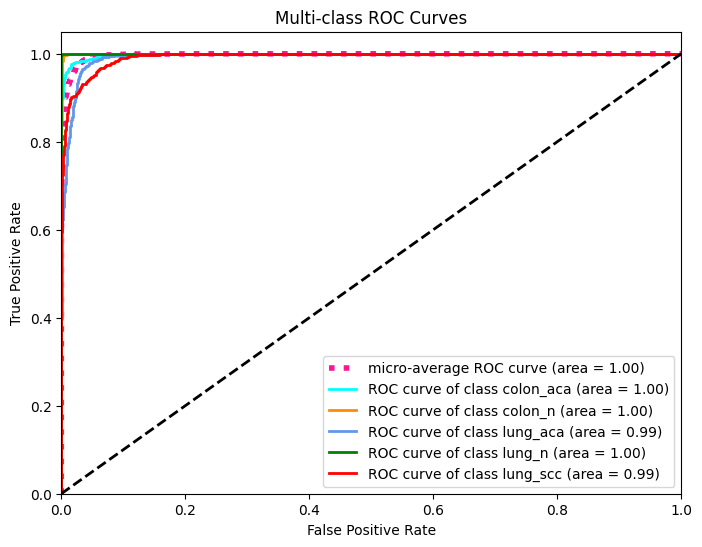

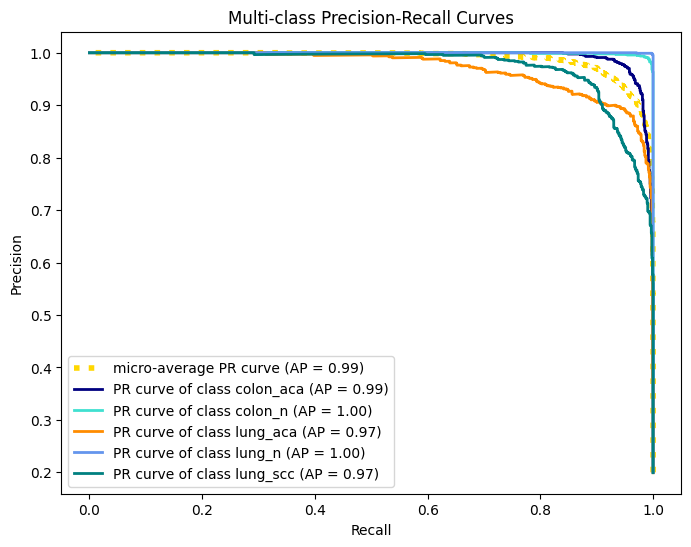

149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9440 - auc: 0.9971 - loss: 0.1369 - precision: 0.9457 - recall: 0.9440
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - accuracy: 0.9166 - auc: 0.9916 - loss: 0.2350 - precision: 0.9224 - recall: 0.9066

Model Comparison Summary:
    Accuracy       AUC  Precision    Recall  F1-score  \
0  94.139963  0.996889   0.942791  0.941400  0.941503   
1  91.800171  0.991972   0.924544  0.909148  0.917964   

   Matthews Correlation Coefficient      Loss         Model  
0                          0.927081  0.142239  sequential_5  
1                          0.897848  0.228698  sequential_4  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, matthews_corrcoef,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

class ModelEvaluator:
    def __init__(self, model, generator, class_names):
        """
        Initialize ModelEvaluator with a model and its test data generator.

        Args:
            model: Trained model instance
            generator: Data generator for evaluation
            class_names: List of class names
        """
        self.model = model
        self.generator = generator
        self.class_names = class_names
        self._cache = {}

    def _get_predictions(self):
        """Get or compute model predictions using caching."""
        if 'predictions' not in self._cache:
            self._cache['predictions'] = self.model.predict(self.generator)
        return self._cache['predictions']

    def _get_true_labels(self):
        """Get true labels from generator."""
        if 'true_labels' not in self._cache:
            self._cache['true_labels'] = self.generator.classes
        return self._cache['true_labels']

    def _get_predicted_classes(self):
        """Get predicted class indices."""
        if 'predicted_classes' not in self._cache:
            predictions = self._get_predictions()
            self._cache['predicted_classes'] = np.argmax(predictions, axis=1)
        return self._cache['predicted_classes']

    def plot_confusion_matrix(self, normalized=False, figsize=(10, 8)):
        """Plot confusion matrix."""
        y_pred_classes = self._get_predicted_classes()
        y_true = self._get_true_labels()

        if normalized:
            cm = confusion_matrix(y_true, y_pred_classes, normalize='true')
            fmt = '.2%'
        else:
            cm = confusion_matrix(y_true, y_pred_classes)
            fmt = 'd'

        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.title('Normalized Confusion Matrix' if normalized else 'Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes, target_names=self.class_names))

    def plot_multiclass_roc(self, figsize=(8, 6)):
        """Plot ROC curves for all classes."""
        y_score = self._get_predictions()
        y_true = self._get_true_labels()
        n_classes = len(self.class_names)

        # Binarize the labels for ROC curve calculation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(figsize=figsize)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of class {self.class_names[i]} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self, figsize=(8, 6)):
        """Plot precision-recall curves for all classes."""
        y_score = self._get_predictions()
        y_true = self._get_true_labels()
        n_classes = len(self.class_names)

        # Binarize the labels
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

        # Compute micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_true_bin.ravel(), y_score.ravel())
        average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")

        plt.figure(figsize=figsize)
        plt.plot(recall["micro"], precision["micro"],
                 label=f'micro-average PR curve (AP = {average_precision["micro"]:.2f})',
                 color='gold', linestyle=':', linewidth=4)

        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2,
                     label=f'PR curve of class {self.class_names[i]} (AP = {average_precision[i]:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Multi-class Precision-Recall Curves')
        plt.legend(loc='lower left')
        plt.show()

    def get_metrics(self):
        """Calculate and return all evaluation metrics."""
        y_pred = self._get_predictions()
        y_true = self._get_true_labels()
        y_pred_classes = self._get_predicted_classes()

        # Calculate metrics using model.evaluate()
        loss, accuracy, auc_score, precision, recall = self.model.evaluate(self.generator)

        # Additional metrics
        f1 = f1_score(y_true, y_pred_classes, average='weighted')
        mcc = matthews_corrcoef(y_true, y_pred_classes)

        metrics = {
            'Accuracy': accuracy * 100,
            'AUC': auc_score,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'Matthews Correlation Coefficient': mcc,
            'Loss': loss
        }

        return pd.DataFrame([metrics])

# Example Usage:

# Assuming `loaded_cnn`, `loaded_vgg16`, `test_gen_cnn`, `test_gen_vgg16`, and `CLASSES` are defined:
cnn_evaluator = ModelEvaluator(loaded_cnn, test_gen_cnn, CLASSES)
vgg16_evaluator = ModelEvaluator(loaded_vgg16, test_gen_vgg16, CLASSES)

# Metrics for CNN
cnn_metrics = cnn_evaluator.get_metrics()
print("CNN Metrics:")
print(cnn_metrics)

# Metrics for VGG16
vgg16_metrics = vgg16_evaluator.get_metrics()
print("VGG16 Metrics:")
print(vgg16_metrics)

# Visualize CNN model performance
cnn_evaluator.plot_confusion_matrix(normalized=True)
cnn_evaluator.plot_multiclass_roc()
cnn_evaluator.plot_precision_recall_curve()

# Compare models
models = [loaded_cnn, loaded_vgg16]
generators = [test_gen_cnn, test_gen_vgg16]
comparison_results, evaluators = compare_models(models, generators, CLASSES)

print("\nModel Comparison Summary:")
print(comparison_results)


# Model Interpretability with Grad-CAM Visualization:

In [ ]:
# Install necessary packages if not already installed
!pip install tensorflow keras matplotlib opencv-python

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import os

# Define Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Args:
        img_array (numpy.ndarray): Preprocessed image array of shape (1, height, width, channels).
        model (tf.keras.Model): Trained Keras model.
        last_conv_layer (tf.keras.layers.Layer): The last Conv2D layer in the model.
        pred_index (int, optional): Index of the class for which to compute Grad-CAM. Defaults to the predicted class.

    Returns:
        numpy.ndarray: Heatmap of shape (height, width).
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = Model(
        inputs=model.input,  # Changed from model.inputs to model.input
        outputs=[last_conv_layer.output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class output value with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the corresponding gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap to keep only positive values
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Define helper function to save and display Grad-CAM
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    Saves and displays the Grad-CAM heatmap overlaid on the original image.

    Args:
        img_path (str): Path to the original image.
        heatmap (numpy.ndarray): Grad-CAM heatmap.
        cam_path (str, optional): Path to save the overlaid image. Defaults to "cam.jpg".
        alpha (float, optional): Transparency factor for the heatmap. Defaults to 0.4.
    """
    # Load the original image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error loading image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (heatmap.shape[1], heatmap.shape[0]))

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Save the image
    cv2.imwrite(cam_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Define function to get sample images from test generator
def get_sample_images(test_gen, num_samples=5):
    """
    Retrieves a specified number of sample images and their labels from the test generator.

    Args:
        test_gen (tf.keras.preprocessing.image.DirectoryIterator): Test data generator.
        num_samples (int, optional): Number of samples to retrieve. Defaults to 5.

    Returns:
        list of tuples: Each tuple contains (image_path, label).
    """
    samples = []
    for i in range(num_samples):
        img_path = test_gen.filepaths[i]
        label = test_gen.labels[i]
        samples.append((img_path, label))
    return samples

# Define function to preprocess images
def preprocess_image(img_path, img_size, model_type='cnn'):
    """
    Loads and preprocesses an image for model prediction.

    Args:
        img_path (str): Path to the image.
        img_size (tuple): Target size for the image.
        model_type (str, optional): Type of model ('cnn' or 'vgg16'). Defaults to 'cnn'.

    Returns:
        numpy.ndarray: Preprocessed image array of shape (1, height, width, channels).
    """
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if model_type == 'vgg16':
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    else:
        img_array = img_array / 255.0
    return img_array

# Define the main Grad-CAM application function
def apply_gradcam_to_samples(test_gen, loaded_cnn, loaded_vgg16, CLASSES, IMG_SIZES, num_samples=5):
    """
    Applies Grad-CAM to a set of sample images using both CNN and VGG16 models.

    Args:
        test_gen (tf.keras.preprocessing.image.DirectoryIterator): Test data generator.
        loaded_cnn (tf.keras.Model): Trained CNN model.
        loaded_vgg16 (tf.keras.Model): Trained VGG16 model.
        CLASSES (list): List of class names.
        IMG_SIZES (dict): Dictionary containing image sizes for models.
        num_samples (int, optional): Number of samples to process. Defaults to 5.
    """
    sample_images = get_sample_images(test_gen, num_samples=num_samples)
    for idx, (img_path, label) in enumerate(sample_images):
        print(f"Processing Image {idx+1}: {img_path}")

        # ------------------- CNN Model -------------------
        try:
            preprocessed_img_cnn = preprocess_image(img_path, IMG_SIZES['cnn'], model_type='cnn')
            # Manually specify the last convolutional layer
            last_conv_layer_cnn = loaded_cnn.get_layer('conv2d_5')
            print(f"Last Conv2D layer in CNN model: {last_conv_layer_cnn.name}")
            # Generate Grad-CAM heatmap
            heatmap_cnn = make_gradcam_heatmap(preprocessed_img_cnn, loaded_cnn, last_conv_layer_cnn)
            # Get model prediction
            preds_cnn = loaded_cnn.predict(preprocessed_img_cnn)
            pred_class_cnn = CLASSES[np.argmax(preds_cnn[0])]
            print(f"Predicted Class (CNN): {pred_class_cnn}")
            # Save and display Grad-CAM for CNN
            cam_path_cnn = f"cam_cnn_{idx+1}.jpg"
            save_and_display_gradcam(img_path, heatmap_cnn, cam_path=cam_path_cnn)
        except Exception as e:
            print(f"Grad-CAM for CNN model failed: {e}")

        # ------------------- VGG16 Model -------------------
        try:
            preprocessed_img_vgg16 = preprocess_image(img_path, IMG_SIZES['vgg16'], model_type='vgg16')
            # Manually specify the last convolutional layer within the nested VGG16 model
            vgg16_nested_model = loaded_vgg16.get_layer('vgg16')
            # Ensure that 'vgg16_nested_model' is a Keras Model to access its layers
            if not isinstance(vgg16_nested_model, tf.keras.Model):
                raise ValueError("The 'vgg16' layer is not a Keras Model.")
            # List all layers within the VGG16 nested model to verify 'block5_conv3' exists
            print("Layers in the VGG16 nested model:")
            for layer in vgg16_nested_model.layers:
                print(f"- {layer.name}")
            # Access the 'block5_conv3' layer
            last_conv_layer_vgg16 = vgg16_nested_model.get_layer('block5_conv3')
            print(f"Last Conv2D layer in VGG16 model: {last_conv_layer_vgg16.name}")
            # Generate Grad-CAM heatmap
            heatmap_vgg16 = make_gradcam_heatmap(preprocessed_img_vgg16, loaded_vgg16, last_conv_layer_vgg16)
            # Get model prediction
            preds_vgg16 = loaded_vgg16.predict(preprocessed_img_vgg16)
            pred_class_vgg16 = CLASSES[np.argmax(preds_vgg16[0])]
            print(f"Predicted Class (VGG16): {pred_class_vgg16}")
            # Save and display Grad-CAM for VGG16
            cam_path_vgg16 = f"cam_vgg16_{idx+1}.jpg"
            save_and_display_gradcam(img_path, heatmap_vgg16, cam_path=cam_path_vgg16)
        except Exception as e:
            print(f"Grad-CAM for VGG16 model failed: {e}")

        print("\n" + "-"*50 + "\n")


In [ ]:
assert train_df['filename'].is_unique
assert val_df['filename'].is_unique
assert test_df['filename'].is_unique

# Ensure no overlap between splits
assert set(train_df['filename']).isdisjoint(set(val_df['filename']))
assert set(train_df['filename']).isdisjoint(set(test_df['filename']))
assert set(val_df['filename']).isdisjoint(set(test_df['filename']))


# Model validation: Trying to figure out why the model seems to have trained too well too quickly.

Potential causes:
* Data Leakage
* Clever Hans Effect
* Testing on Non-Independent Data
* Data Preprocessing Artifacts:
 * Normalization applied inconsistently between training and testing.
 * Using preprocessed features that include target information.

Image Similarity Analysis


Image Similarity Analysis
Total comparisons: 10000
Similar pairs found: 7837 (threshold: 0.95)

Similarity Statistics:
Mean: 0.9585
Std Dev: 0.0127
Median: 0.9608
Range: [0.8842, 0.9901]

Class-wise Statistics:
              mean     std  count
same_class                       
False       0.9568  0.0129   7992
True        0.9654  0.0090   2008

Statistical Test:
T-statistic: 28.0337
P-value: 1.5561e-166

Top 5 Most Similar Pairs:
                                                              source_path                                                          target_path  similarity source_class target_class
6761  data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4971.jpeg   data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc525.jpeg    0.990100     lung_scc     lung_scc
6722  data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4971.jpeg  data/lung_colon_image_set/lung_image_sets/lung_scc/lungscc2952.jpeg    0.987768     lung_scc     lung_scc
5584  data/lung_colon

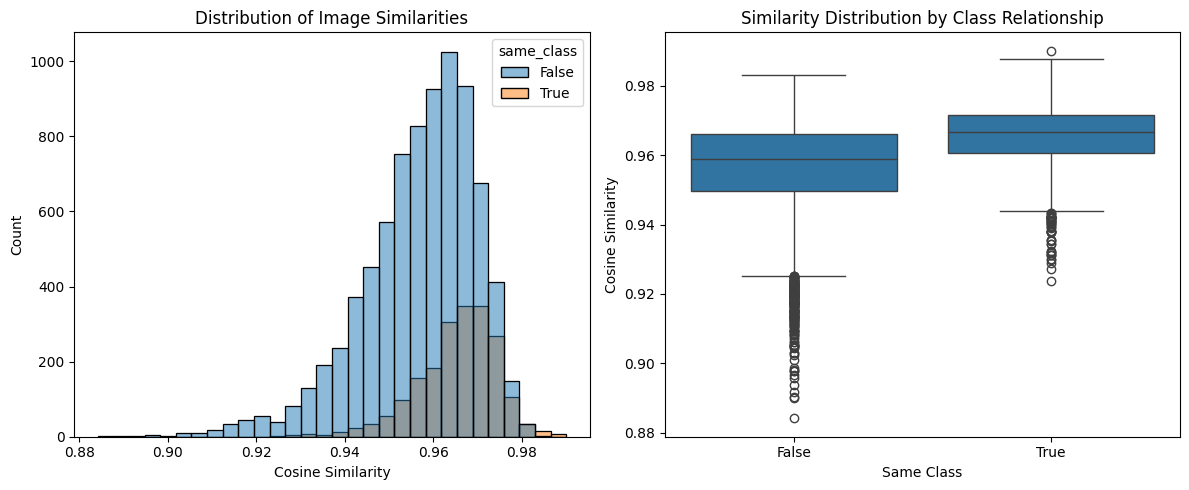

In [ ]:
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

def analyze_image_similarities(source_df, target_df, threshold=0.95, sample_size=100):
    """
    Analyze similarities between images in source and target datasets.

    Args:
        source_df: DataFrame containing source image paths
        target_df: DataFrame containing target image paths
        threshold: Similarity threshold for flagging similar images
        sample_size: Number of images to sample from each dataset

    Returns:
        dict: Dictionary containing similarity statistics
    """
    # Sample datasets
    source_sample = source_df.sample(min(len(source_df), sample_size))
    target_sample = target_df.sample(min(len(target_df), sample_size))

    similarities = []
    similar_pairs = []

    # Calculate similarities
    for _, source_row in source_sample.iterrows():
        source_arr = get_image_array(source_row['filename'])
        source_label = source_row['label']

        for _, target_row in target_sample.iterrows():
            target_arr = get_image_array(target_row['filename'])
            target_label = target_row['label']

            similarity = cosine_similarity(
                source_arr.reshape(1, -1),
                target_arr.reshape(1, -1)
            )[0][0]

            similarities.append({
                'similarity': similarity,
                'same_class': source_label == target_label,
                'source_class': source_label,
                'target_class': target_label
            })

            if similarity > threshold:
                similar_pairs.append({
                    'source_path': source_row['filename'],
                    'target_path': target_row['filename'],
                    'similarity': similarity,
                    'source_class': source_label,
                    'target_class': target_label
                })

    # Convert to DataFrame for analysis
    similarities_df = pd.DataFrame(similarities)

    # Calculate statistics
    stats_dict = {
        'n_comparisons': len(similarities),
        'n_similar_pairs': len(similar_pairs),
        'mean_similarity': similarities_df['similarity'].mean(),
        'std_similarity': similarities_df['similarity'].std(),
        'median_similarity': similarities_df['similarity'].median(),
        'min_similarity': similarities_df['similarity'].min(),
        'max_similarity': similarities_df['similarity'].max(),
        'similar_pairs': similar_pairs
    }

    # Calculate class-wise statistics
    class_stats = similarities_df.groupby('same_class')['similarity'].agg([
        'mean', 'std', 'count'
    ]).round(4)

    # Perform t-test between same-class and different-class similarities
    same_class = similarities_df[similarities_df['same_class']]['similarity']
    diff_class = similarities_df[~similarities_df['same_class']]['similarity']
    t_stat, p_value = stats.ttest_ind(same_class, diff_class)

    # Add to stats dictionary
    stats_dict.update({
        'class_stats': class_stats,
        't_statistic': t_stat,
        'p_value': p_value
    })

    # Create visualizations
    plt.figure(figsize=(12, 5))

    # Similarity distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=similarities_df, x='similarity', hue='same_class', bins=30)
    plt.title('Distribution of Image Similarities')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Count')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=similarities_df, x='same_class', y='similarity')
    plt.title('Similarity Distribution by Class Relationship')
    plt.xlabel('Same Class')
    plt.ylabel('Cosine Similarity')

    plt.tight_layout()
    stats_dict['figure'] = plt.gcf()

    return stats_dict

# Function to print the analysis results
def print_similarity_analysis(stats_dict):
    print("\nImage Similarity Analysis")
    print("=" * 50)
    print(f"Total comparisons: {stats_dict['n_comparisons']}")
    print(f"Similar pairs found: {stats_dict['n_similar_pairs']} (threshold: 0.95)")
    print("\nSimilarity Statistics:")
    print(f"Mean: {stats_dict['mean_similarity']:.4f}")
    print(f"Std Dev: {stats_dict['std_similarity']:.4f}")
    print(f"Median: {stats_dict['median_similarity']:.4f}")
    print(f"Range: [{stats_dict['min_similarity']:.4f}, {stats_dict['max_similarity']:.4f}]")

    print("\nClass-wise Statistics:")
    print(stats_dict['class_stats'])

    print("\nStatistical Test:")
    print(f"T-statistic: {stats_dict['t_statistic']:.4f}")
    print(f"P-value: {stats_dict['p_value']:.4e}")

    if stats_dict['n_similar_pairs'] > 0:
        print("\nTop 5 Most Similar Pairs:")
        similar_pairs_df = pd.DataFrame(stats_dict['similar_pairs'])
        print(similar_pairs_df.nlargest(5, 'similarity')[
            ['source_path', 'target_path', 'similarity', 'source_class', 'target_class']
        ].to_string())

    # Display the figure
    plt.show()

# Usage:
# Run the analysis between test and train sets
stats = analyze_image_similarities(test_df, train_df)
print_similarity_analysis(stats)


Analyzing class: lung_scc


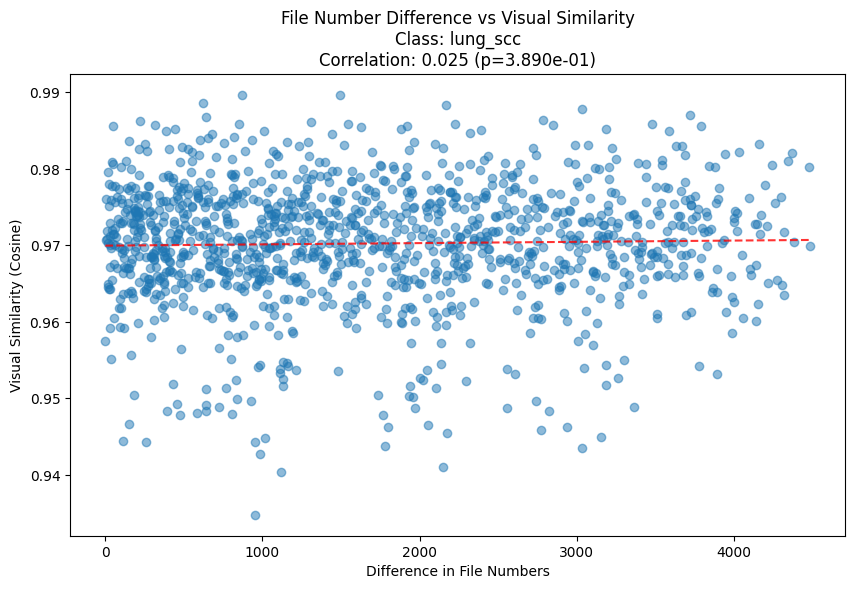


Analyzing class: lung_aca


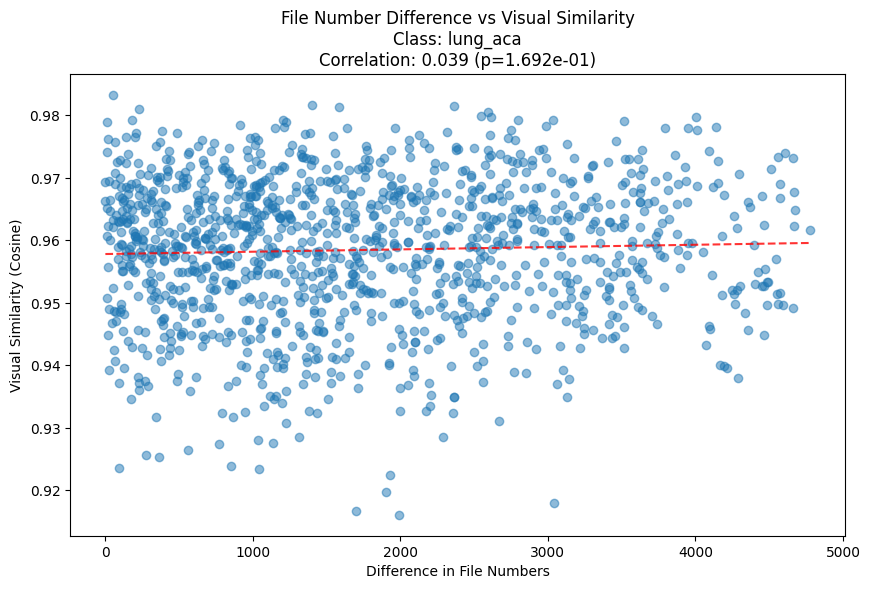


Analyzing class: lung_n


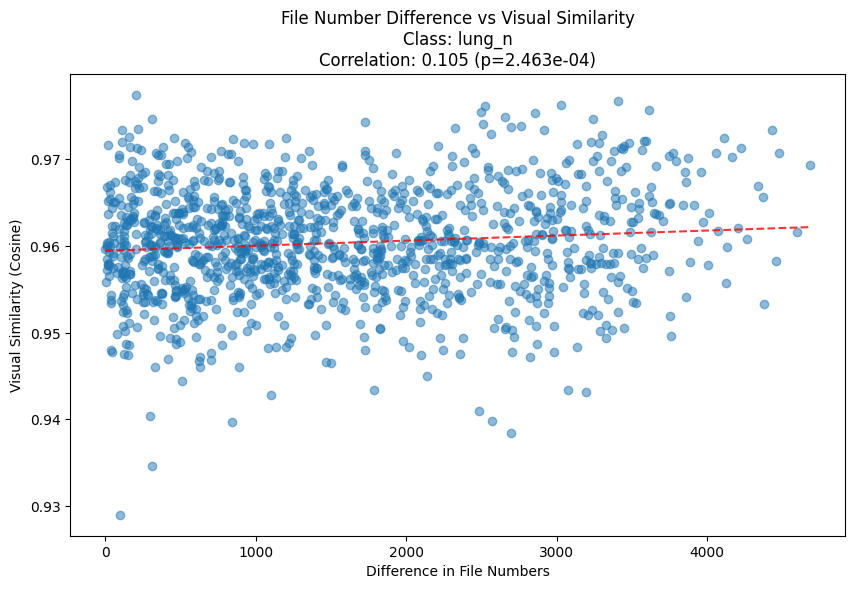


Analyzing class: colon_aca


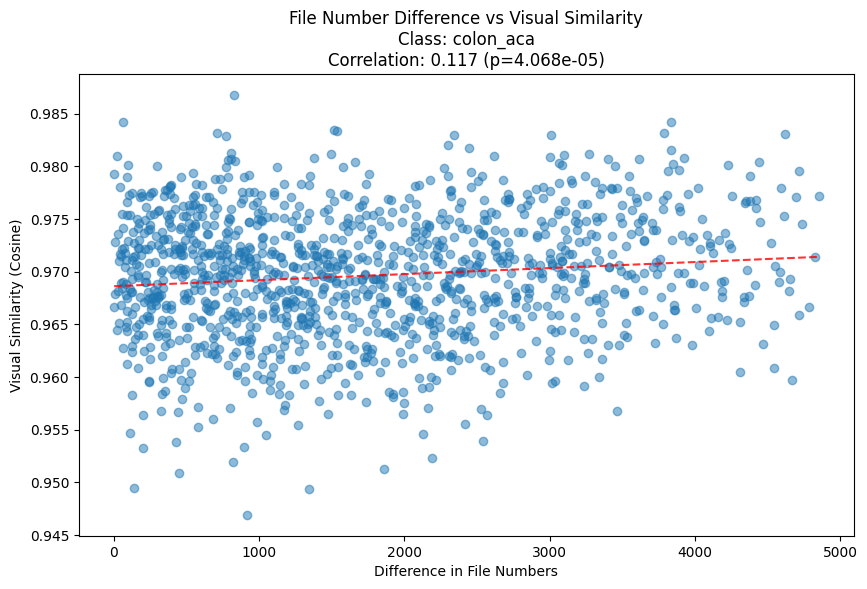


Analyzing class: colon_n


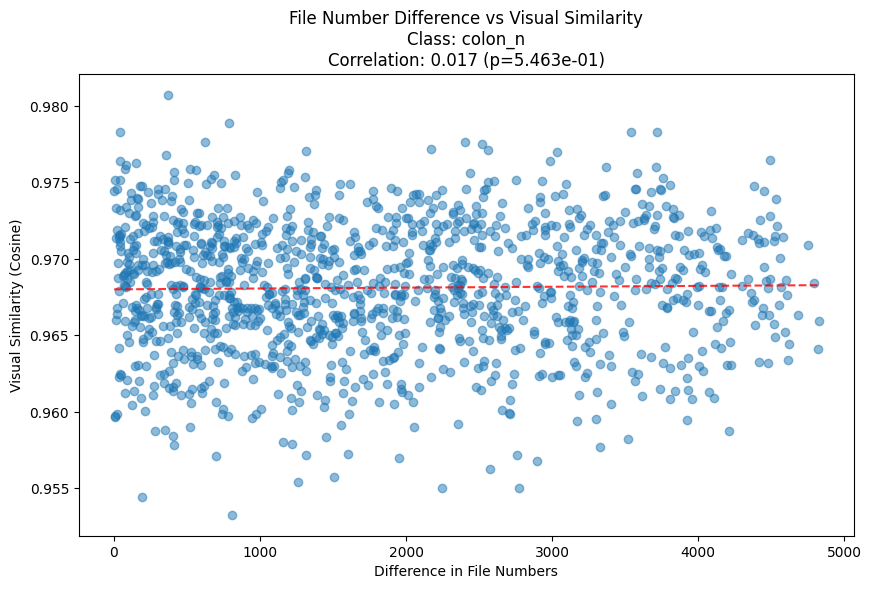


Summary Statistics:
       class  correlation  p_value  n_comparisons  mean_similarity  \
0   lung_scc       0.0246   0.3890           1225           0.9702   
1   lung_aca       0.0393   0.1692           1225           0.9584   
2     lung_n       0.1046   0.0002           1225           0.9604   
3  colon_aca       0.1170   0.0000           1225           0.9696   
4    colon_n       0.0173   0.5463           1225           0.9681   

   std_similarity  mean_number_diff  std_number_diff  
0          0.0079         1686.1837        1177.2284  
1          0.0114         1737.2114        1205.5069  
2          0.0062         1545.9339        1107.3177  
3          0.0059         1746.9927        1207.8092  
4          0.0042         1837.6000        1283.3268  


In [ ]:
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def extract_number(filename):
    """Extract numerical suffix from filename."""
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def get_image_array(path):
    """Convert image to numpy array."""
    img = Image.open(path)
    img = img.resize((224, 224))  # Standardize size
    return np.array(img).flatten()

def analyze_filename_visual_correlation(df, sample_size=100):
    """
    Analyze correlation between filename number differences and visual similarities.

    Args:
        df: DataFrame containing 'filename' and 'label' columns
        sample_size: Number of images to sample from each class
    """
    results = []

    # Analyze each class separately
    for class_name in df['label'].unique():
        print(f"\nAnalyzing class: {class_name}")

        # Get files for this class
        class_files = df[df['label'] == class_name]

        # Sample if necessary
        if len(class_files) > sample_size:
            class_files = class_files.sample(sample_size)

        file_numbers = []
        similarities = []
        number_diffs = []

        # Get list of files and their numbers
        files_and_numbers = [(row['filename'], extract_number(row['filename']))
                           for _, row in class_files.iterrows()]

        # Filter out any files where we couldn't extract a number
        files_and_numbers = [(f, n) for f, n in files_and_numbers if n is not None]

        # Compare each pair
        for i in range(len(files_and_numbers)):
            file1, num1 = files_and_numbers[i]
            img1_array = get_image_array(file1)

            for j in range(i + 1, len(files_and_numbers)):
                file2, num2 = files_and_numbers[j]
                img2_array = get_image_array(file2)

                # Calculate similarity
                similarity = cosine_similarity(
                    img1_array.reshape(1, -1),
                    img2_array.reshape(1, -1)
                )[0][0]

                # Calculate number difference
                number_diff = abs(num1 - num2)

                similarities.append(similarity)
                number_diffs.append(number_diff)

        # Calculate correlation
        correlation, p_value = stats.pearsonr(number_diffs, similarities)

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(number_diffs, similarities, alpha=0.5)
        plt.xlabel('Difference in File Numbers')
        plt.ylabel('Visual Similarity (Cosine)')
        plt.title(f'File Number Difference vs Visual Similarity\nClass: {class_name}\n'
                 f'Correlation: {correlation:.3f} (p={p_value:.3e})')

        # Add trend line
        z = np.polyfit(number_diffs, similarities, 1)
        p = np.poly1d(z)
        plt.plot(sorted(number_diffs), p(sorted(number_diffs)), "r--", alpha=0.8)

        plt.show()

        # Store results
        results.append({
            'class': class_name,
            'correlation': correlation,
            'p_value': p_value,
            'n_comparisons': len(similarities),
            'mean_similarity': np.mean(similarities),
            'std_similarity': np.std(similarities),
            'mean_number_diff': np.mean(number_diffs),
            'std_number_diff': np.std(number_diffs)
        })

    # Create summary DataFrame
    results_df = pd.DataFrame(results)
    print("\nSummary Statistics:")
    print(results_df.round(4))

    return results_df

results = analyze_filename_visual_correlation(df, sample_size=50)

Conclusions:
1. Overall Very High Similarities (Avg. 0.95-0.97) within classes:
2. Not much Filename Number Correlations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.9 MB/s eta 0:00:00


100%|██████████| 4750/4750 [00:45<00:00, 105.19it/s]


Number of duplicate images found: 115
List of duplicate images:
                                                filename      label  \
8830   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
7940   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
24396  data/lung_colon_image_set/colon_image_sets/col...  colon_aca   
846    data/lung_colon_image_set/lung_image_sets/lung...     lung_n   
19217  data/lung_colon_image_set/colon_image_sets/col...    colon_n   

             image_hash  
8830   cae72e8b285b12cd  
7940   a76d53b26c11a647  
24396  e1b93ae6068b3f84  
846    953e79e009cf5cd0  
19217  eb72258f1a7c4853  


100%|██████████| 4692/4692 [00:14<00:00, 315.27it/s] 

Number of near-duplicate pairs found: 65

Duplicate group with hash 81864f677923b91b:


filename     label
8365  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
7220  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 8299f9f0cc81ceec:


filename     label
7190  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8451  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 894b22cb1efede04:


filename      label
24669  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22530  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 89f1aa8af0d55dc4:


filename     label
13779  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
11193  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash 8bab91d64db4c613:


filename    label
19381  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19319  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash 8bf95ac296059fa2:


filename   label
429   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
3281  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 8fdf30e33e61201e:


filename     label
6543  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
7343  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 91915dca246f8b2f:


filename   label
3198  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
2507  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 929cd1a79e698786:


filename   label
3278  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
2228  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 93a1961d5d5f8863:


filename   label
3668  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
623   data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 953e79e009cf5cd0:


filename   label
846   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
3374  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash 95c54cba59f28b16:


filename      label
23786  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21475  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 9a53daa67b473340:


filename     label
5347  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8546  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash 9c71f1e092c15f4e:


filename     label
11751  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10497  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash 9cbca585f5e9a111:


filename      label
24847  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
20432  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash 9ccb7fe5680c889a:


filename    label
18633  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15947  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash 9de45043942eab5f:


filename     label
12647  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10537  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash a76d53b26c11a647:


filename     label
7940  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8999  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash a959bc8442b2c5f7:


filename    label
16142  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18014  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ab6bda64c9a52499:


filename     label
7160  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
5829  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash abad47121fc5ca0d:


filename   label
634   data/lung_colon_image_set/lung_image_sets/lung...  lung_n
4236  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash ad1323e60d1bf274:


filename      label
23112  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24264  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash aff43584ed3950c2:


filename   label
1526  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
349   data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash b128d5d6b7291e61:


filename     label
7057  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
6662  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash b4136b83ebf41d24:


filename    label
15655  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19194  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash b4af6ae87954c306:


filename   label
3093  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
73    data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash b59bb66b74647084:


filename      label
22337  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24144  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash b858b68f9b829bb0:


filename      label
22144  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22965  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21868  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash bccc1010f867d7f4:


filename   label
3196  data/lung_colon_image_set/lung_image_sets/lung...  lung_n
1302  data/lung_colon_image_set/lung_image_sets/lung...  lung_n


Duplicate group with hash be6ad2eda19013d8:


filename     label
7519  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8859  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash c23de896edd848c3:


filename    label
16832  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19291  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash c55779a25f47c904:


filename     label
11210  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
13670  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash c7b2329a964a6d4b:


filename    label
19561  data/lung_colon_image_set/colon_image_sets/col...  colon_n
19707  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ca96baa98493276e:


filename      label
24151  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21710  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash cae72e8b285b12cd:


filename     label
8830  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
5211  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash cb185ce9425d07fc:


filename     label
14097  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10843  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash cd639c2e352c33d4:


filename      label
22590  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
23209  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash ce62bac9e4d7403a:


filename    label
18461  data/lung_colon_image_set/colon_image_sets/col...  colon_n
17022  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash d02237e70a3d6f46:


filename      label
24534  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24950  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash d2548efa981bb585:


filename     label
13623  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
11681  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Duplicate group with hash d31564ee11eb6a4a:


filename    label
17324  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18924  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash d43c16f63b9e8942:


filename      label
22299  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24297  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash d475d5a5b6c69051:


filename     label
6296  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8744  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash d76f4a166088b16f:


filename      label
20534  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24268  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash dad92d2d95651436:


filename    label
17884  data/lung_colon_image_set/colon_image_sets/col...  colon_n
18809  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash e1b93ae6068b3f84:


filename      label
24396  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21182  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash e80b95653f9f0332:


filename     label
5999  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
6295  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash e847b228dc569d3c:


filename     label
6416  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca
8567  data/lung_colon_image_set/lung_image_sets/lung...  lung_aca


Duplicate group with hash ea94a11bebdc40f1:


filename      label
21839  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
21812  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash eb72258f1a7c4853:


filename    label
19217  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15663  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ec065785d7276329:


filename    label
15415  data/lung_colon_image_set/colon_image_sets/col...  colon_n
15493  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash ec0e328c66b355d3:


filename      label
20472  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24306  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash ee93b103b026e86f:


filename      label
20792  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
24645  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash f121deb4427dd2d0:


filename    label
16309  data/lung_colon_image_set/colon_image_sets/col...  colon_n
17812  data/lung_colon_image_set/colon_image_sets/col...  colon_n


Duplicate group with hash f15e071c8fb28363:


filename      label
24434  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
20605  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash f28cb5865393ab51:


filename      label
21837  data/lung_colon_image_set/colon_image_sets/col...  colon_aca
22740  data/lung_colon_image_set/colon_image_sets/col...  colon_aca


Duplicate group with hash fdc05a2270d2d976:


filename     label
11000  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc
10480  data/lung_colon_image_set/lung_image_sets/lung...  lung_scc


Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca326.jpeg
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1212.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4626.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2656.jpeg
Images in group 2:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca431.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4532.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4585.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1293.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca699.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca4344.jpeg
Ima

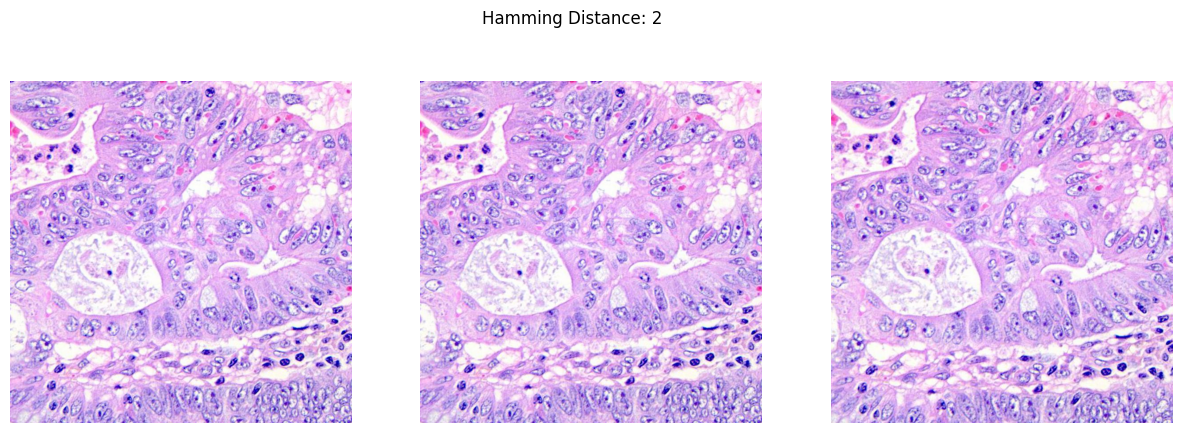

In [ ]:
!pip install imagehash Pillow tqdm

import imagehash
from PIL import Image
from tqdm import tqdm



# Compute Image Hashes

# Initialize an empty dictionary to store hashes
hashes = {}

# Iterate over all images and compute hashes
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Open the image file
        image = Image.open(row['filename'])
        # Compute the perceptual hash
        image_hash = imagehash.phash(image)
        # Store the hash as a string
        hashes[row['filename']] = str(image_hash)
    except Exception as e:
        # Handle images that can't be opened
        hashes[row['filename']] = None

# Add the hashes to the DataFrame
df['image_hash'] = df['filename'].map(hashes)


# Identify Duplicates

# Find Exact Duplicates

# Count the number of occurrences of each hash
hash_counts = df['image_hash'].value_counts()

# Identify hashes that occur more than once
duplicate_hashes = hash_counts[hash_counts > 1].index

# Filter the DataFrame to show only duplicate images
duplicates_df = df[df['image_hash'].isin(duplicate_hashes)].copy()

print(f"Number of duplicate images found: {len(duplicates_df)}")
print("List of duplicate images:")
print(duplicates_df[['filename', 'label', 'image_hash']].head())



# Find Near-Duplicates

from itertools import combinations
from collections import defaultdict

# Create a mapping from image hashes to filenames
hash_to_filenames = defaultdict(list)
for idx, row in df.iterrows():
    hash_to_filenames[row['image_hash']].append(row['filename'])

# Convert hash strings to integers for computation
hash_to_int = {h: int(h, 16) for h in hash_to_filenames if h is not None}

# Set a Hamming distance threshold
threshold = 5  # Adjust this value based on desired sensitivity

# Find near-duplicates
near_duplicates = []

# Generate combinations of hashes
hash_list = list(hash_to_int.keys())
for i in tqdm(range(len(hash_list))):
    hash1 = hash_to_int[hash_list[i]]
    filenames1 = hash_to_filenames[hash_list[i]]
    for j in range(i + 1, len(hash_list)):
        hash2 = hash_to_int[hash_list[j]]
        filenames2 = hash_to_filenames[hash_list[j]]
        # Compute Hamming distance
        hamming_dist = bin(hash1 ^ hash2).count('1')
        if hamming_dist <= threshold:
            near_duplicates.append({
                'hash1': hash_list[i],
                'hash2': hash_list[j],
                'filenames1': filenames1,
                'filenames2': filenames2,
                'hamming_distance': hamming_dist
            })

print(f"Number of near-duplicate pairs found: {len(near_duplicates)}")



# Analyze Results

# View Exact Duplicates

# Group duplicates by image_hash
duplicate_groups = duplicates_df.groupby('image_hash')

# Display duplicates
for image_hash, group in duplicate_groups:
    print(f"\nDuplicate group with hash {image_hash}:")
    display(group[['filename', 'label']])


# View Near-Duplicates

# Display near-duplicate pairs
for nd in near_duplicates[:5]:  # Show first 5 for brevity
    print(f"\nHamming Distance: {nd['hamming_distance']}")
    print("Images in group 1:")
    for fname in nd['filenames1']:
        print(f" - {fname}")
    print("Images in group 2:")
    for fname in nd['filenames2']:
        print(f" - {fname}")



# Visualization
import matplotlib.pyplot as plt

def display_images(image_paths, title):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    fig.suptitle(title)
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display images for the first near-duplicate pair
if near_duplicates:
    nd = near_duplicates[0]
    display_images(nd['filenames1'] + nd['filenames2'], f"Hamming Distance: {nd['hamming_distance']}")

Checking for Patches (I believe I did this before do the previous check for "Filename Number Correlations". Based on the results of that, patches might not be a thing, but I'm not 100% sure.

In [ ]:
import re

def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def check_sequential_patches(df, window=10):
    sequences = []
    for label in df['label'].unique():
        label_files = df[df['label'] == label]['filename']
        numbers = sorted([extract_number(f) for f in label_files])

        # Look for close sequential numbers
        for i in range(len(numbers)-1):
            if numbers[i+1] - numbers[i] <= window:
                sequences.append((label, numbers[i], numbers[i+1]))

    return sequences

# Check for nearby sequence numbers within each set
print("Checking for potentially related patches...")
print("\nIn Training set:")
train_sequences = check_sequential_patches(train_df)
print(f"Found {len(train_sequences)} potentially related pairs")
if train_sequences:
    print("First few examples:", train_sequences[:5])

# Check for nearby sequence numbers across sets
def check_cross_set_similarity(df1, df2, window=10):
    df1_numbers = [(extract_number(f), l) for f, l in zip(df1['filename'], df1['label'])]
    df2_numbers = [(extract_number(f), l) for f, l in zip(df2['filename'], df2['label'])]

    close_pairs = []
    for num1, label1 in df1_numbers:
        for num2, label2 in df2_numbers:
            if label1 == label2 and abs(num1 - num2) <= window:
                close_pairs.append((label1, num1, num2))

    return close_pairs

print("\nChecking for potentially related patches across sets...")
train_test_similar = check_cross_set_similarity(train_df, test_df)
print(f"Found {len(train_test_similar)} potentially related pairs between train and test")
if train_test_similar:
    print("First few examples:", train_test_similar[:5])

Checking for potentially related patches...

In Training set:
Found 14 potentially related pairs
First few examples: [('colon_n', 2585, 2593), ('colon_n', 3360, 3370), ('colon_n', 3633, 3639), ('colon_n', 3673, 3677), ('colon_aca', 1330, 1339)]

Checking for potentially related patches across sets...
Found 712 potentially related pairs between train and test
First few examples: [('colon_n', 555, 561), ('colon_n', 555, 552), ('colon_n', 555, 554), ('colon_n', 555, 557), ('colon_n', 555, 548)]


The 712 potentially related pairs between train and test may be the source of data leakage through related patches from the same whole slide images (WSIs) being split across training and test sets.

To fix this, I'm trying to implement a more robust train/test split that keeps all patches from the same WSI together



In [ ]:
def get_patch_group(filename):
    # Group patches by hundreds to keep related patches together
    number = extract_number(filename)
    return number // 100

def strategic_split(df, test_size=0.2, val_size=0.2):
    # Get unique patch groups
    df['patch_group'] = df['filename'].apply(get_patch_group)
    unique_groups = df['patch_group'].unique()

    # Split at the group level
    test_groups = set(np.random.choice(
        unique_groups,
        size=int(len(unique_groups) * test_size),
        replace=False
    ))

    remaining_groups = set(unique_groups) - test_groups
    val_groups = set(np.random.choice(
        list(remaining_groups),
        size=int(len(unique_groups) * val_size),
        replace=False
    ))
    train_groups = remaining_groups - val_groups

    # Split the dataframe
    train_df = df[df['patch_group'].isin(train_groups)]
    val_df = df[df['patch_group'].isin(val_groups)]
    test_df = df[df['patch_group'].isin(test_groups)]

    return train_df, val_df, test_df